# Harmonic Perturbations 

Following [Gudmundsson 2003](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2002JB002107), let's define our synthetic beds $z_{\rm b}$ as: 

$$
    B_{\rm synth_k} = B_{\rm F2019} + B'_{\rm k},
$$

where $B_{\rm synth_k}$ is the $k$-th synthetic bed profile as a function of distance along the flowline, $B_{\rm F2019}$ is the observed Farinotti bed (in this case smoothed), and $B'_{\rm k}$ is the $k$-th perturbation. 

Perturbations will take the form:
$$
B'_{\rm k} =  A_{\rm k} \, \sin{\left( \frac{2\pi}{k \tilde{H}} \right)}
$$
where $A_{\rm k} = \lambda_{\rm k} R$ (m) and $\lambda_{\rm k}$ (m) are the amplitude and wavelength of the $k^{\rm th}$ bed perturbation, respectively, $R$ is the amplitude-to-wavelength ratio, $\tilde{H}$=100 m is the characteristic ice thickness and k=[5,15]. The value of $\tilde{H}$ is based on mean ice-thickness of the reference bed, rounded down to be a clean number. The minimum value of $k$ corresponds to a perturbation wavelength of $k \tilde{H} = 500$\,m, and is chosen based on the Nyquist wavelength of 400\,m determined from the 200\,m horizontal grid spacing of the inverse model.Finally, a composite bed $B_{\rm synth}$ is also defined by adding the sum of all perturbations for $k=[5,15]$ to $B_{\rm F2019}$:

$$
B_{\rm synth} = B_{\rm F2019} + \sum_{k=5}^{15} \, 
A_{\rm k} \, \sin{\left( \frac{2\pi}{k \tilde{H}} \right)}.
$$

The goal of this notebook is to find an appropriate values of $R$ which produces significant perturbations without changing the overall shape of the bed, or producing a bed that is physically unreasonable. 

In [1]:
import numpy as np 
import scipy.signal as signal 
from scipy import interpolate
import matplotlib.pyplot as plt 

plt.rcParams['text.usetex'] = True

# Load the smoothed F2019 data
x_c = np.loadtxt('../Data/Topography/REF_SurfTopo.dat')[:,0]    # x-coordinate
z_s = np.loadtxt('../Data/Topography/REF_SurfTopo.dat')[:,1]    # surface elevation (m a.s.l.)
z_b = np.loadtxt('../Data/Topography/REF_BedTopo.dat')[:,1]     # bed evelation (m a.s.l.)

# interpolation
func = interpolate.interp1d(x_c, z_b)
x_c = np.linspace(0,x_c[-1],1000)
z_b = func(x_c)

# linear bed-trend for de-trending
trend = np.polyval(np.polyfit(x_c, z_b, 1), x_c)

Now, lets define the create some perturbed beds and test out various amplitude to wavelength ratios $R$

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# SET PARAMETER VALUES
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
H_bar = 100.0         # [m] characteristic ice-thickness
N     = 15            # [ ] How many harmonics to compute
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# SET INPUT DATA
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
x     = x_c.copy()   
dx    = np.abs(x[1] - x[0])
M     = x.shape[0]
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# SET OUTPUT VECTORS
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
synth = np.zeros((M,N,6)) 
# DIM 0: x coordinate
# DIM 1: k harmnoics
# DIM 2: R (A/λ) ratios
pxx   = np.zeros((M//2 + 1,N,6))
# DIM 0: wavenumbers
# DIM 1: k harmnoics
# DIM 2: R (A/λ) ratios
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CALCULATE
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Itterate over the ratio of amplitude to wavelength
for i, ratio in enumerate(np.geomspace(10e-3, 10e-2, 6)):
    
    # Itterate over the harmonics
    for j, k in enumerate(np.arange(5,N+1,1)):
        λ = k*H_bar                 # [m] Wavelength 
        A = ratio * λ               # [m] Amplitude of k-th harmonic
        
        # Compute the k-th harmonic
        synth[:,j,i]  = A*np.sin(((2*np.pi)/λ)*x)
        
        # Compute the periodogram of the k-th harmonic
        f, pxx[:,j,i] = signal.periodogram(synth[:,j,i], fs=1/dx, scaling='spectrum')

First, let's just plot the perturbations over the linearly detrended surface. 

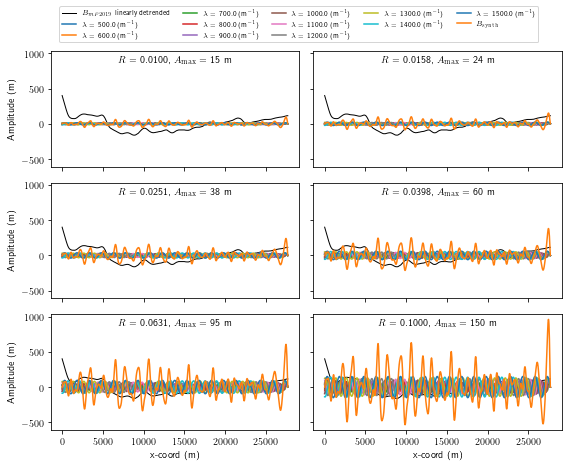

In [3]:
fig, ax = plt.subplots(3,2, figsize= (8, 6), 
                       sharey=True, sharex=True)

axes = ax.ravel()
for i, ratio in enumerate(np.geomspace(10e-3, 10e-2, 6)):
    
    if i == 0:
        axes[i].plot(x[::-1], z_b-trend, color='k', lw=1,
             label='$B_{\rm F2019}$ linearly detrended')
    else:
        axes[i].plot(x[::-1], z_b-trend, color='k', lw=1)
        
    for j, k in enumerate(np.arange(5,N+1,1)):
        λ = k*H_bar # [m] Wavelength 
        
        if i == 0:
            axes[i].plot(x[::-1], synth[:,j,i],
                        label=r'$\lambda$ = {:6.1f} (m$^{{-1}}$)'.format(λ))
        else:
            axes[i].plot(x[::-1], synth[:,j,i])
            
    axes[i].text(0.5,0.9,
                 r'$R$ = {:1.4f}, $A_{{\rm max}} =$ {:.0f} m'.format(ratio,H_bar*N*ratio),
                 transform=axes[i].transAxes, horizontalalignment='center')
    
    if i == 0:  
        axes[i].plot(x[::-1], np.sum(synth[:,:,i], axis=1),
                    label=r'$B_{\rm synth}$')
    else:
        axes[i].plot(x[::-1], np.sum(synth[:,:,i], axis=1))
        
    if i % 2 == 0: 
        axes[i].set_ylabel('Amplitude (m)')
    if i > 3:
        axes[i].set_xlabel('x-coord (m)')
        
fig.legend(loc='upper center', bbox_to_anchor= (0.525, 1.075), ncol=5,
            fontsize='x-small', borderaxespad=0, fancybox=True)

fig.tight_layout()
fig.savefig('../plots/spectral/synthetic_waveforms.png', bbox_inches='tight', facecolor='w', dpi = 300 )

Next, to get a sense of what these beds would actually look like, let's plot the summed bed for each $R$ value over the F2019 data. 

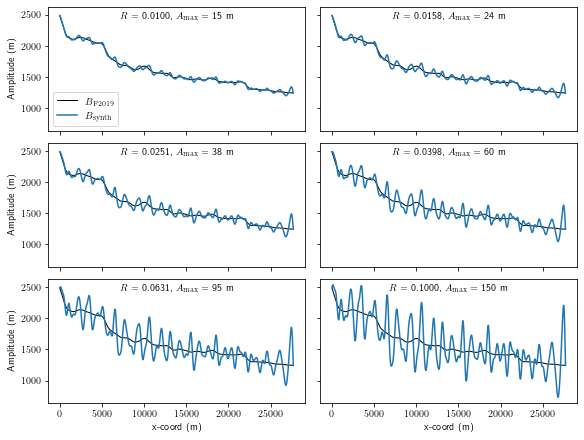

In [4]:
fig, ax = plt.subplots(3,2, figsize= (8, 6), 
                       sharey=True, sharex=True,
                       constrained_layout=True)

axes = ax.ravel()
for i, ratio in enumerate(np.geomspace(10e-3, 10e-2, 6)):
    
    axes[i].plot(x[::-1], z_b, color='k', lw=1,
                 label=r'$B_{\rm F2019}$')

    axes[i].text(0.5,0.9,
                 r'$R$ = {:1.4f}, $A_{{\rm max}} =$ {:.0f} m'.format(ratio,H_bar*N*ratio),
                 transform=axes[i].transAxes, horizontalalignment='center')
    
    axes[i].plot(x[::-1], z_b+np.sum(synth[:,:,i], axis=1),
                label=r'$B_{\rm synth}$')
    if i % 2 == 0: 
        axes[i].set_ylabel('Amplitude (m)')
    if i > 3:
        axes[i].set_xlabel('x-coord (m)')
        
axes[0].legend(loc=3)

Finally, let's plot the periodogram for each $R$ value tested. 

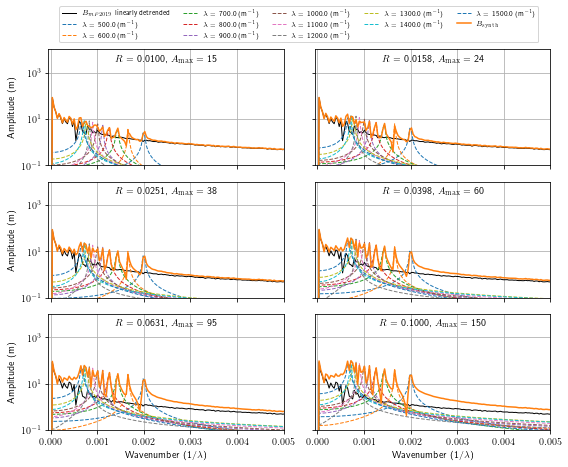

In [5]:
fig, ax = plt.subplots(3,2, figsize= (8, 6), 
                       sharey=True, sharex=True)

axes = ax.ravel()

bed_f, bed_pxx = signal.periodogram(z_b-trend, fs=1/dx, scaling='spectrum')

for i, ratio in enumerate(np.geomspace(10e-3, 10e-2, 6)):
    
    if i == 0:
        axes[i].plot(bed_f, np.sqrt(bed_pxx), color='k', lw=1,
             label='$B_{\rm F2019}$ linearly detrended')
    else:
        axes[i].plot(bed_f, np.sqrt(bed_pxx), color='k', lw=1)
        
    for j, k in enumerate(np.arange(5,N+1,1)):
        λ = k*H_bar # [m] Wavelength 
        
        if i == 0:
            axes[i].plot(f, np.sqrt(pxx[:,j,i]), lw=1, ls = '--',
                        label=r'$\lambda$ = {:6.1f} (m$^{{-1}}$)'.format(λ))
        else:
            axes[i].plot(f, np.sqrt(pxx[:,j,i]), lw=1, ls = '--')
            
    axes[i].text(0.5,0.9,
                 r'$R$ = {:1.4f}, $A_{{\rm max}} =$ {:.0f}'.format(ratio,H_bar*N*ratio),
                 transform=axes[i].transAxes, horizontalalignment='center')

    sum_f, sum_pxx = signal.periodogram((z_b-trend)+ np.sum(synth[:,:,i], axis=1), 
                                        fs=1/dx, scaling='spectrum')
    
    if i == 0:  
        axes[i].plot(sum_f, np.sqrt(sum_pxx),
                    label=r'$B_{\rm synth}$')
    else:
        axes[i].plot(sum_f, np.sqrt(sum_pxx))
        
    if i % 2 == 0: 
        axes[i].set_ylabel('Amplitude (m)')
    if i > 3:
        axes[i].set_xlabel('Wavenumber (1/$\lambda$)')
    
    axes[i].grid(True, which='major')

axes[0].set_yscale('log')
axes[0].set_ylim(10e-2,10e3)
axes[0].set_xlim(-.00005, 0.005)

fig.legend(loc='upper center', bbox_to_anchor= (0.525, 1.075), ncol=5,
            fontsize='x-small', borderaxespad=0, fancybox=True)

fig.tight_layout()
fig.savefig('../plots/spectral/perturbed_spectograms_log.png', bbox_inches='tight', facecolor='w', dpi = 300 )

From all three sets of plots, it seems any value of $R$ greater than 0.0158 is nearly impossible to justify. We settled an $R$ value of 0.01 since it's an easy number to work with. 

--- 
With a selected value of $R=0.01$ lets take a closer look at the individual perturbations and the summed bed. 

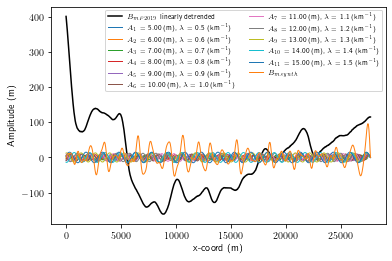

In [6]:
fig, ax = plt.subplots()

ax.plot(x_c[::-1], z_b-trend, c='k', label='$B_{\rm F2019}$ linearly detrended')

summed = np.zeros(x_c.shape)
λ      = H_bar*np.arange(5,N+1,1.0)

sins   = np.zeros((x_c.shape[0],len(λ)))

for i in range(len(λ)):
    A = 10e-3*λ[i]
    sins[:,i] = A*np.sin(((2*np.pi)/λ[i])*x_c)
    ax.plot(x_c[::-1], sins[:,i], lw = 1.0, 
            label='$A_{{{}}}$ = {:<5.2f} (m),  $\lambda$ = {:2.1f} (km$^{{-1}}$)'.format(i+1, A, λ[i]/1e3))

ax.plot(x_c[::-1], np.sum(sins, axis=1), lw = 1.0, label='$B_{\rm synth}$')

ax.set_ylabel('Amplitude (m)'); 
ax.set_xlabel('x-coord (m)'); 

ax.legend(ncol=2, fontsize='x-small')

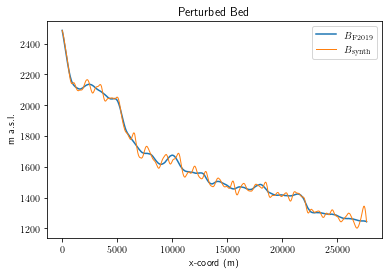

In [7]:
fig, ax = plt.subplots()

ax.plot(x_c[::-1], z_b, label=r'$B_{\rm F2019}$')

ax.plot(x_c[::-1], z_b+np.sum(sins, axis=1), lw = 1.0, label=r'$B_{\rm synth}$')

ax.set_ylabel('m a.s.l.'); 
ax.set_xlabel('x-coord (m)'); 
ax.set_title( 'Perturbed Bed')

ax.legend()

Great! We do not write any of the perturbed beds to files in this notebook. Instead I've written a `python` script to create the perturbed beds, which can called from a `bash` job submission script. The `python` script can be found at [`SRC/utils/make_bed.py`](https://github.com/andrewdnolan/Harmonic_Beds/blob/main/elmer/SRC/utils/make_bed.py). For information on how to use the `make_bed.py` script see below: 

In [10]:
! python3 ../SRC/utils/make_bed.py -h

usage: make_bed.py [-h] -B BED_PROFILE -O OUT_PATH -H H_BAR -N HARMONICS -R
                   RATIO [-S]

optional arguments:
  -h, --help            show this help message and exit
  -B BED_PROFILE, --bed_profile BED_PROFILE
                        Path to Farinotti bed profile
  -O OUT_PATH, --out_path OUT_PATH
                        Path to write pretubed bed profile
  -H H_BAR, --H_bar H_BAR
                        Mean ice thickness (m)
  -N HARMONICS, --harmonics HARMONICS
                        Number of harmnoics to compute
  -R RATIO, --ratio RATIO
                        ratio of amplitude to wavelength (m/m)
  -S, --sum             Evaluate the series from 1 to N.Otherwise only the Nth
                        harmonic is computed
